<a href="https://colab.research.google.com/github/ekrell/ams_ai_shortcourse_2024/blob/main/modules/physicsai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMS AI Short Course: Introduction to physics-informed machine learning

This Colab Notebook demonstrates how we might include physics into our machine learning models.

In the environmental sciences, we generally have some prior physical knowledge about the system we are interested in modeling. In this module, we will introduce some ways in which physical knowledge can be integrated with machine learning to improve predictions.

**Some examples in the environmental sciences**

- <a href="https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.098302"> T. Beucler et al."Enforcing Analytic Constraints in Neural Networks Emulating Physical Systems."</a>
Phys. Rev. Lett. 126, 09830
- <a href="https://royalsocietypublishing.org/doi/full/10.1098/rsta.2020.0093"> K. Kashinath et al. 2021 Physics-informed machine learning: case studies for weather and climate modelling. Phil. Trans. R. Soc. A.3792020009320200093</a>
- <a href="https://iopscience.iop.org/article/10.1088/1748-9326/acbbe0/meta">R. ElGhawi et al. "Hybrid modeling of evapotranspiration: inferring stomatal and aerodynamic resistances using combined physics-based and machine learning" Env. Res. Lett. 18, 034039, 2023.</a>

**Goal**
Using simple examples of physical systems, we will explore how prior physical knowledge can be included in machine learning models


**Methods to be discussed:**
- Soft and Hard Physical Constraints
- Hybrid physics-ML approaches
- Physics-Informed Neural Networks

We load pre-trained neural network weights that we will use in the example later here:

In [27]:
#!wget "https://github.com/ekrell/ams_ai_shortcourse_2024/raw/main/data/physicsai/vanilla_network_weights"
#!wget "https://github.com/ekrell/ams_ai_shortcourse_2024/raw/main/data/physicsai/pinn_network_weights"
#!wget "https://github.com/ekrell/ams_ai_shortcourse_2024/raw/main/data/physicsai/pinndisc_network_weights"

## Embedding physical knowledge into our neural networks


Neural networks can act as universal function approximators (Hornik et al. 1989). This property makes them very useful for supervised regression tasks where we want learn a non-linear mapping between inputs and outputs. However, unlike physical models, which generally have some limiting factors in terms of how "wrong" they can be, when neural networks are wrong, they generally produce extremely unphysical predictions. In particular, unconstrained neural networks will generalize very poorly outside of the data regime in which they are trained.

### Soft and hard physical constraints
One way that we can improve a neural networks prediction for physical models is to include constraints on the neural network's prediction. We often distinguish between two types of constraints:

- **Soft physical constraints** refer to adding an additional term to the loss function in order to impose a physical constraint that we know a priori about our system. These will be problem specific, as they will depend on the specific physical laws that we want to enforce.

- **Hard physical constraints** refer to updating the architecture of our neural network to impose specific physical functions.


### Symmetries, invariances, and equivariances
By including known symmetries into our machine learning models, we can often reduce the complexity of our machine learning models, and improve the robustness of our predictions.

One way to include this type of prior physical knowledge is through the training process. For example, if we don't expect that rotations of our input would have a physical effect on our output, we can impose translational or rotational invariance by augmenting our data sets with random translations or rotations.

Another approach is through the architecture of the network itself. Different types of models implicity assume different types of invariances.

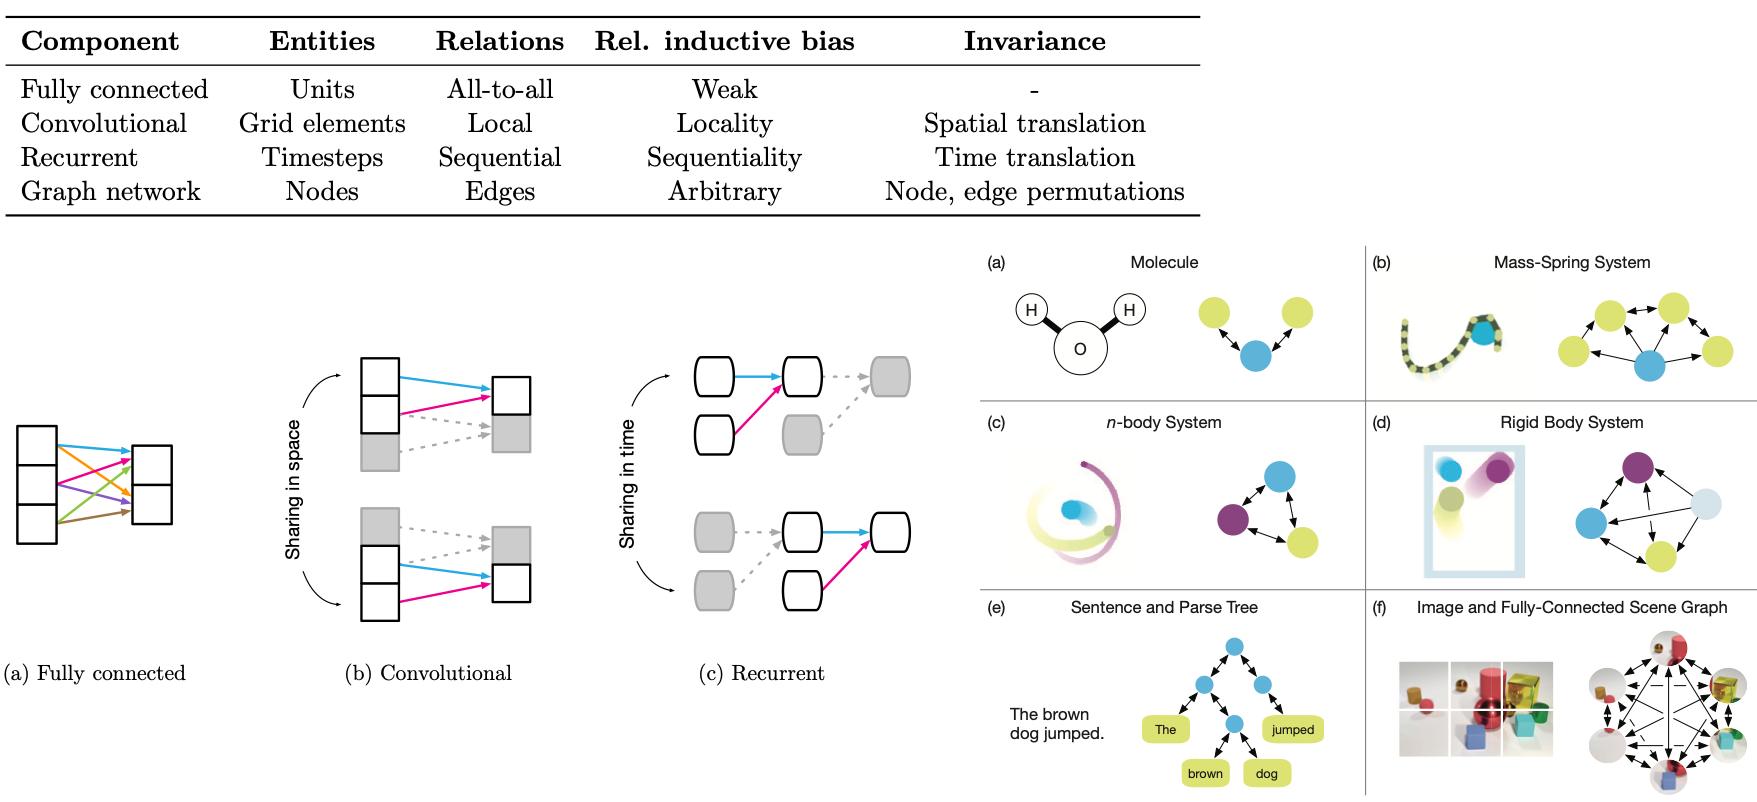

The above figures come from <a href="https://arxiv.org/pdf/1806.01261.pdf" >Battaglia et al. 2018</a>

## Hybrid Physics-ML approaches

Sometimes we want to integrate a lot of prior physical knowledge into our system, but we also want to include a neural network prediction to model parts of the system that we don't know. One way to do this is through using hybrid-physics machine learning models. Hybrid physics-machine learning models are ones that include both domain knowledge (first principles physical knowledge about our system) as well as data-driven methods.

Physical models lend themselves to interpretability, but suffer from high computational costs (in some cases) and can also have uncertainty in terms of both parameters in the equations and the structure of the equations themselves.

Data-driven models are learned directly from data or higher resolution simulations that explicity resolve physics that may be uncertain at lower resolutions. However, they are hard to interpret, and the parameters that they learn do not correspond to parameters of the system, and thus may not be physically interpretable.

By combining both physical models and data-driven models, hybrid models will have improved intretability over purely data-driven models, but also may have improved accuracy by their ability to learn unknown or uncertain physics directly from observations.

## Physics-Informed Neural Networks

One type of hybrid-physics machine learning model is a physics-informed neural networks. Physics-informed neural networks (Raissi et al. 2019) are an approach that we can use to enforce physical constraints on our machine learning model.

When we are in a regime where don't have a lot of data but do have prior physical knowledge, we can regularize our neural network with differential equations. The example that we will go through below to demonstrate how this works in practice largely follows the tutorial from  <a href="https://medium.com/@theo.wolf/physics-informed-neural-networks-a-simple-tutorial-with-pytorch-f28a890b874a"> Theo Wolf </a>. We'll start by loading some python packages.

In [ ]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch

As an example, we will use Newton's law of cooling. This equation describes the temperature of an object (for example, a cup of coffee) placed into an environment that is at a different temperature (here, we'll assume the cup of coffee is placed onto the table at room temperature). We can write this as an ordinary differential equation describing the rate of heat loss from the object:
\begin{equation}
\frac{dT(t)}{dt} = r(T_{env}-T(t))
\end{equation}
where $T(t)$ is the temperature of our cup of coffee at time t, $T_{env}$ is the temperature of the ambient environment, and $r$ is the cooling rate.


In this case we can find an analytical solution to this ordinary differential equation, describing the temperature of our cup of coffee after $t$ seconds as
\begin{equation}
T(t) = T_{env}+(T_{0}-T_{env})e^{-rt}
\end{equation}
where $T_{0}$ is the initial temperature of our cup of coffee, and $T(t)$ is the temperature of the coffee after $t$ seconds have passed.
We write the time dependence of our cup of coffee in python:

In [ ]:
def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

We will use the analytical solution to show the true solution of our differential equation, given an initial temperature of our cup of coffee at $T_{0}=100$ $^{\circ}C$, and the initial temperature of the environment is $T_{env}=25$ $^{\circ}C$. We plot this function below, and also create a training data set of 10 data points for our machine learning model. These 10 data points represent measurements of our cup of coffee over time (so we'll add some normally distributed noise). These 10 measurements are evenly spaced over the first 300 seconds that we are observing our cup of coffee.

Text(0.5, 0, 'Time (s)')

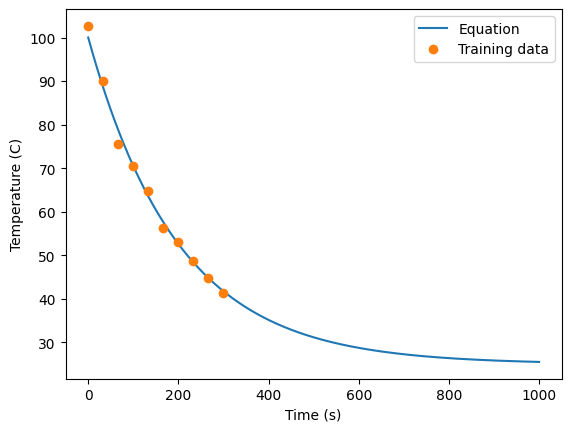

In [ ]:
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

First, we will look at what happens if we train a simple neural network (a fully connected multi-layer perceptron with ReLU activations). The code below creates an MLP using the Pytorch framework, and can be used for both training and inference.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def np_to_th(x):
  # this is just a simple helper function to turn numpy arrays into pytorch tensors
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)
class Net(nn.Module):
    def __init__(self,input_dim,output_dim,n_units=100,epochs=1000,loss=nn.MSELoss(),lr=1e-3,
                 loss2=None,loss2_weight=0.1,) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        # the code here are (the layers of our MLP)
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU())

        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        # this is where we train the neural network
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        # this is where we do inference
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()

We will first train the neural network with mean squared error (MSE) loss. The input for our network here is the 10 times that we measured our cup of coffee $t$, and the output here are the 10 temperatures that we measured at those times.

Because the neural network acts as a univeral function approximator, we will denote the neural network as $f(t|\theta)$. That is, it takes in the time $t$ and maps this to a prediction for the temperature, given the values of the weights of the neural network $\theta$.

MSE loss for the 10 data points is calculated by
\begin{equation}
Loss_{MSE} = \frac{1}{10}\sum_{j}^{10} (f(t|\theta)-T_{j})^2
\end{equation}

The code below trains the MLP for 20000 epochs.

In [ ]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

Epoch 0/20000, loss: 4539.68
Epoch 2000/20000, loss: 2514.90
Epoch 4000/20000, loss: 2130.21
Epoch 6000/20000, loss: 653.88
Epoch 8000/20000, loss: 6.85
Epoch 10000/20000, loss: 2.50
Epoch 12000/20000, loss: 2.41
Epoch 14000/20000, loss: 2.38
Epoch 16000/20000, loss: 2.35
Epoch 18000/20000, loss: 2.33


Text(0.5, 0, 'Epoch')

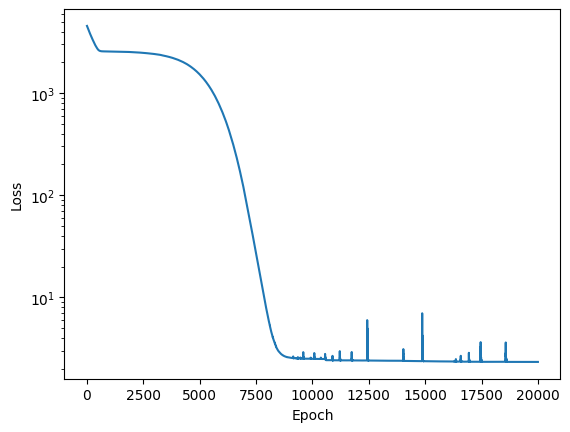

In [ ]:
losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
# This line saves the network weights
#torch.save(net.state_dict(), "vanilla_network_weights")

In [ ]:
# this line reloads the saved network weights
net.load_state_dict(torch.load("/content/vanilla_network_weights"))

<All keys matched successfully>

Now let's look at how well the trained neural network does. We first use the train neural network to predict the temperature of our cup of coffee over the entire 1000 seconds in our data set. The code below does inference with the trained neural network to give us predictions for the temperature.

In [ ]:
preds = net.predict(times)

Now, let's plot the predictions of the neural network and compare it with the true equation for the temperature of the cup of coffee.

Text(0.5, 0, 'Time (s)')

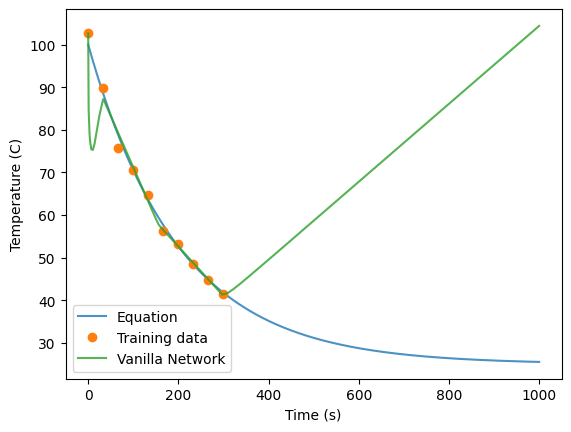

In [ ]:
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Vanilla Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

As can be seen, the neural network does a decent job of predicting the temperature of the cup of coffee for the first 300 seconds, but it does a very poor job extrapolating to future times (t>300 seconds) because the neural network has no physical constraints on its prediction. It also is not quite sure how to handle the initial points.

Next, we will look at how to use a physics-informed neural network instead. The idea behind PINN's is that we can impose a physical constraint on our neural network prediction, given our prior physical knowledge about the system. To do this, we will use what are called colloction points. Collocation points are points that we will evaluate our network at during the training process to ensure that the neural network prediction will be consistent with our known prior physical knowledge.

In this case, our prior physical knowledge is Newton's cooling law, so we can write this constraint as
\begin{equation}
g(t,T) = \frac{dT(t)}{dt} - r(T_{env}-T(t)) = 0
\end{equation}.

We can use Newton's cooling law to write a physics loss term for the data as

\begin{equation}
g(t,f(t|\theta)) = \frac{df(t|\theta)}{dt} - r(T_{env}-f(t|\theta))
\end{equation}
where we have just replaced the temperature with the prediction from our neural network.

We will then evaluate this physics loss term at $M = 1000$ collocation points. Our physics loss term is
\begin{equation}
Loss_{physics} = \frac{1}{M}\sum_{i}^{M} \left(\frac{df(t_{i}|\theta)}{dt_{i}} - r(T_{env}-f(t_{i}|\theta))\right)^2
\end{equation}.

In order to evalute this term, we need to take the derivative of our neural network as its being trained. We can use automatic differentiation to do this.

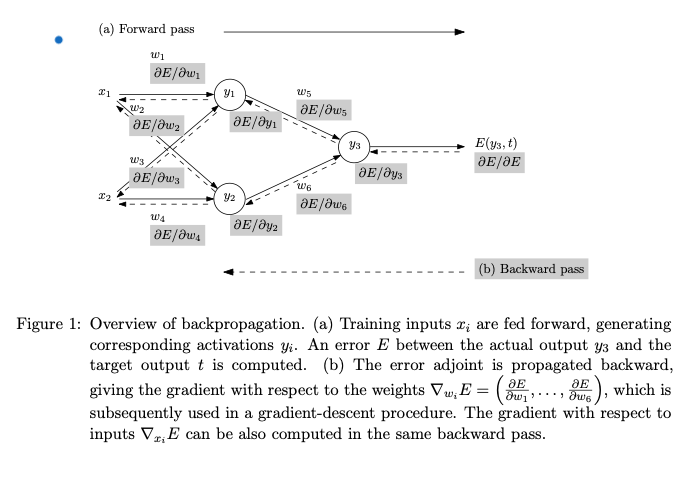

The above figure comes from <a href="https://arxiv.org/abs/1502.05767">Baydin et al. 2015 </a>.

Pytorch has a function called *torch.autograd.grad* that uses automatic diffentiation to compute and return the sum of gradients of outputs with respect to the inputs (the Jax package has similar functionality that can be used with Tensorflow).

In [ ]:
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect to an input."""
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)
def physics_loss(model: torch.nn.Module):
    """The physics loss of the model"""
    # make M = 1000 collocation points
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True)
    # run the collocation points through the network
    temps = model(ts)
    # get the gradient
    dT = grad(temps, ts)[0]
    # compute the ODE
    ode = dT - R*(Tenv - temps)
    # MSE of ODE
    return torch.mean(ode**2)

Now that we have the physics loss function, we will train the model with both the MSE loss term and the physics loss term. The training objective is now
\begin{equation}
Loss_{MSE}+\lambda Loss_{physics}
\end{equation}
where $\lambda$ is a hyperparameter that weighs the second loss term. Here we will choose $\lambda$=1. We will again train the network for 20000 epochs, but now training for both loss terms.

In [ ]:
netpinn = Net(1,1, loss2=physics_loss, epochs=20000, loss2_weight=1, lr=1e-5).to(DEVICE)

Epoch 0/20000, loss: 4367.53
Epoch 2000/20000, loss: 2456.76
Epoch 4000/20000, loss: 1771.26
Epoch 6000/20000, loss: 269.14
Epoch 8000/20000, loss: 4.35
Epoch 10000/20000, loss: 2.05
Epoch 12000/20000, loss: 1.97
Epoch 14000/20000, loss: 1.64
Epoch 16000/20000, loss: 1.53
Epoch 18000/20000, loss: 1.43


Text(0.5, 0, 'Epoch')

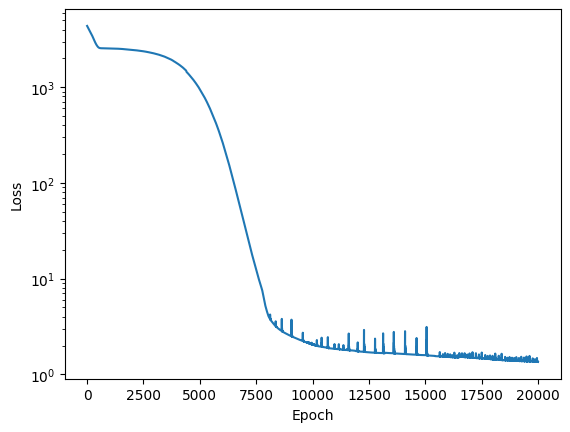

In [ ]:
losses = netpinn.fit(t, T)
plt.plot(losses)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [ ]:
# This line saves the network weights
#torch.save(netpinn.state_dict(), "pinn_network_weights")

In [ ]:
# This line reloads the saved network weights
netpinn.load_state_dict(torch.load("/content/pinn_network_weights"))

<All keys matched successfully>

Now that the model is trained, we will look at the predictions from the PINN model.

In [ ]:
predspinn = netpinn.predict(times)

Text(0.5, 0, 'Time (s)')

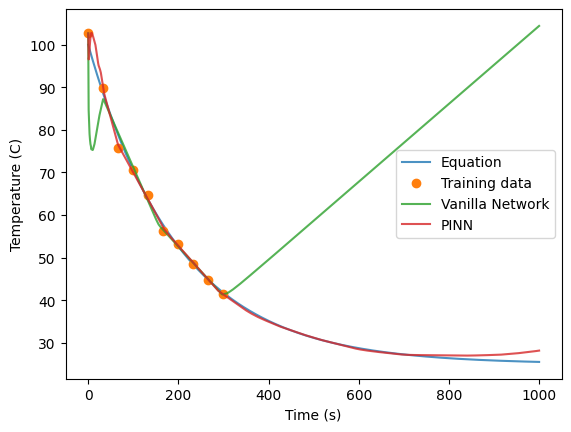

In [ ]:
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predspinn, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'Vanilla Network', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

The PINN performs much better than the original Vanilla network that was trained without any physics constraint.

Next, we will look at how we can use the PINN to learn unknown parameters in our model. For example, if we did not know the parameter $r$ in our differential equation, how can we use a PINN to estimate what it is?

Recall that Newton's law of cooling is
\begin{equation}
\frac{dT(t)}{dt} = r(T_{env}-T(t))
\end{equation}
where $T(t)$ is the temperature of our cup of coffee at time t, $T_{env}$ is the temperature of the ambient environment, and $r$ is the cooling rate.

To add $r$ as a differentiable parameter that will be learned along with the weights of the network, we need to update our neural network, and also update our physics loss function.  

The code below updates our network to include a trainable parameter for $r$. This is defined as a pytorch Parameter, which means that it is differentiable.

In [ ]:
class NetDiscovery(Net):
    def __init__(self,input_dim,output_dim,n_units=100,epochs=1000,loss=nn.MSELoss(),lr=0.001,
                 loss2=None,loss2_weight=0.1,) -> None:
        super().__init__(input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight)

        self.r = nn.Parameter(data=torch.tensor([0.]))

To update the physics loss term, we use the current value of the $r$ parameter, rather than known value of the $r$ (recall that we used $r=0.005$ when we created our data set)

In [ ]:
def physics_loss_discovery(model: torch.nn.Module):
    # make M = 1000 collocation points
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    # run the collocation points through the network
    temps = model(ts)
    # get the gradient
    dT = grad(temps, ts)[0]
    # compute the ODE
    # note that here we now use model.r rather than R because this parameter will be updated as the model is trained
    ode = model.r * (Tenv - temps) - dT
    # MSE of ODE
    return torch.mean(ode**2)

Now we will train the network with this updated loss function. The network will learn how to predict the temperature, given the time, and the current value for $r$.

In [ ]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)


Epoch 0/40000, loss: 4837.56
Epoch 4000/40000, loss: 2500.29
Epoch 8000/40000, loss: 1903.43
Epoch 12000/40000, loss: 144.07
Epoch 16000/40000, loss: 3.10
Epoch 20000/40000, loss: 2.35
Epoch 24000/40000, loss: 1.87
Epoch 28000/40000, loss: 1.50
Epoch 32000/40000, loss: 1.48
Epoch 36000/40000, loss: 1.34


Text(0.5, 0, 'Epoch')

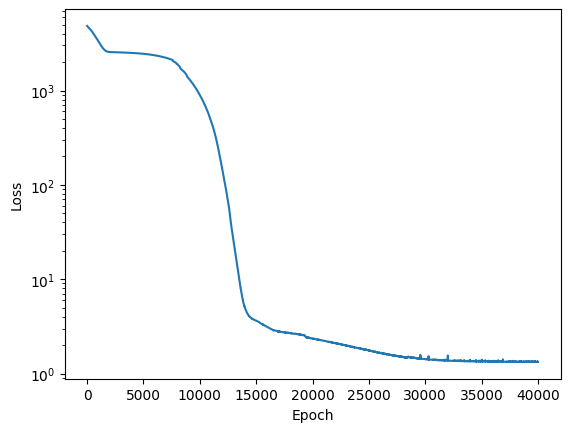

In [ ]:
losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epoch")


In [ ]:
# This line saves the network weights
#torch.save(netdisc.state_dict(), "pinndisc_network_weights")

In [ ]:
# This line reloads the network weights
netdisc.load_state_dict(torch.load("/content/pinndisc_network_weights"))

<All keys matched successfully>

Similar to before, we will use the trained model to predict the temperature over the entire range of values.

In [ ]:
predspinndiscover = netdisc.predict(times)

Now we can look at how the prediction compares against our previous models and the true values. Even though the model had to learn the $r$ parameter along with the functional dependence of Temperature as a function of time, the predictions are on par with the predictions of the PINN model where we used the cooling rate that we knew in the physics loss function.

Text(0.5, 0, 'Time (s)')

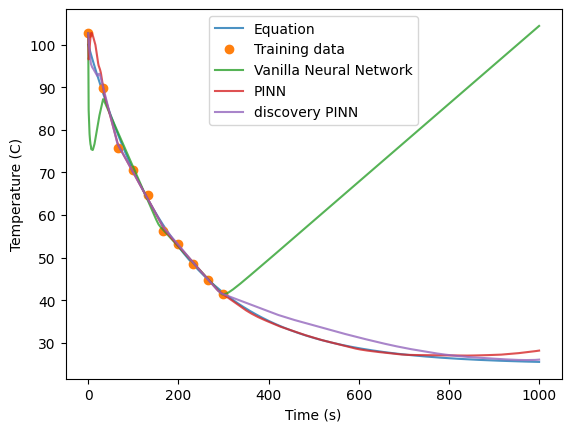

In [ ]:
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predspinn, alpha=0.8)
plt.plot(times, predspinndiscover, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'Vanilla Neural Network','PINN','discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Finally we can look at the value that was learned by the network for $r$. This just requires the following code:

In [ ]:
print(netdisc.r.item())

0.004949529189616442


Our model found a value very close to the real value $r=0.005$.